## Observational social learning task with a reinforcement-learning-based network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import pandas as pd
import time
from NEF_RL import *

In [2]:
def get_RL(env, sid, trial, alpha):
    human = pd.read_pickle(f"data/carrabin.pkl").query("sid==@sid")
    expectation = 0
    expectations = [0]
    obs_time = 0
    obs_times = [0]
    subdata = human.query("trial==@trial & stage<=5")
    colors = subdata['color'].to_numpy()
    for color in colors:
        error = color - expectation
        expectation += alpha*error
        expectations.append(expectation)
    return np.array(expectations)

In [10]:
def get_RLz(env, sid, trial, alpha, z):
    human = pd.read_pickle(f"data/jiang.pkl").query("sid==@sid")
    expectation = 0
    expectations = [0]
    obs_time = 0
    obs_times = [0]
    for stage in range(4):
        subdata = human.query("trial==@trial & stage==@stage")
        observations = subdata['color'].to_numpy()
        RDs = subdata['RD'].to_numpy()
        for o, obs in enumerate(observations):
            stg = int(subdata.iloc[o]['stage'])
            RD = 0 if stg<2 else RDs[o]
            error = obs - expectation
            LR = alpha + z*RD
            LR = np.clip(LR, 0, 1)
            expectation += LR * error
            expectations.append(expectation)
            obs_time += env.T
            obs_times.append(obs_time)
    return np.array(obs_times), np.array(expectations)

### Carrabin

In [4]:
trial = 1
sid = 1
alpha = 0.15  # pd.read_pickle(f"data/RL_carrabin_{sid}_params.pkl")['alpha'].unique()[0]

env = Environment(dataset='carrabin', sid=sid, trial=trial)
net, sim = simulate_RL(env=env, alpha=alpha, z=0, seed_net=sid, progress_bar=True)
RL = get_RL(env=env, sid=sid, trial=trial, alpha=alpha)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

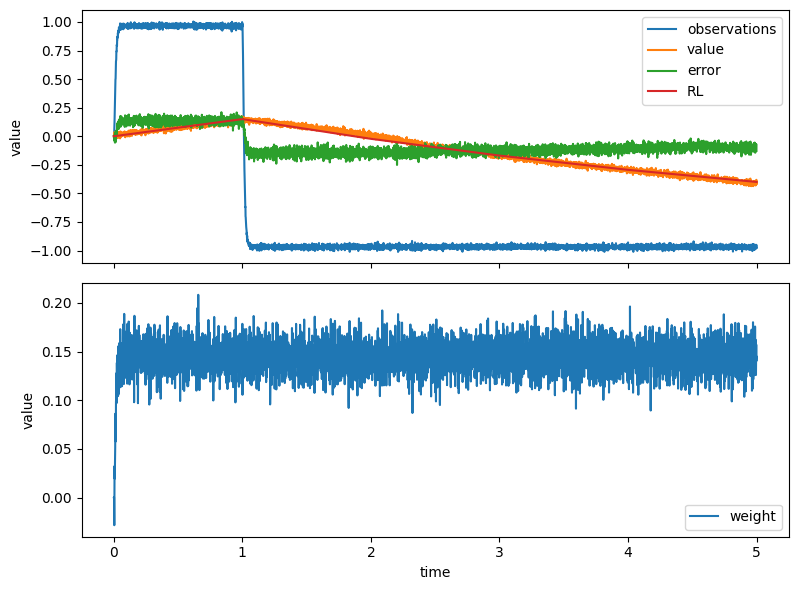

In [9]:
times = sim.trange().flatten()
input_obs = sim.data[net.probe_input_obs].flatten()
obs = sim.data[net.probe_obs].flatten()
weight = sim.data[net.probe_weight].flatten()
error = sim.data[net.probe_error].flatten()
value = sim.data[net.probe_value].flatten()
def cumulative_average(a):
    return np.cumsum(a) / np.arange(1, len(a) + 1)
cumavg = cumulative_average(input_obs)
obs_times = np.arange(0, 6*env.T, env.T)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True)
sns.lineplot(x=times, y=obs, ax=axes[0], label='observations')
sns.lineplot(x=times, y=value, ax=axes[0], label='value')
sns.lineplot(x=times, y=error, ax=axes[0], label='error')
sns.lineplot(x=obs_times, y=RL, ax=axes[0], label='RL')
sns.lineplot(x=times, y=weight, ax=axes[1], label='weight')
# axes[1].axhline(0, color='k', lw=0.1)
# axes[1].axvline(env.T, color='k', ls='--')
# axes[1].axvline(2*env.T, color='k', ls='--')
# axes[1].axvline(3*env.T, color='k', ls='--')
# axes[1].axvline(4*env.T, color='k', ls='--')
# axes[1].axvline(5*env.T, color='k', ls='--')
axes[0].set(xlabel='time', ylabel='value')
axes[1].set(xlabel='time', ylabel='value', xticks=obs_times)
plt.tight_layout()

### Jiang

In [11]:
trial = 1
sid = 1
alpha = 0.15
z = 0.5

env = Environment(dataset='jiang', sid=sid, trial=trial)
net, sim = simulate_RL(env=env, alpha=alpha, z=z, seed_net=sid, progress_bar=True)
obs_times, RLz = get_RLz(env=env, sid=sid, trial=trial, alpha=alpha, z=z)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

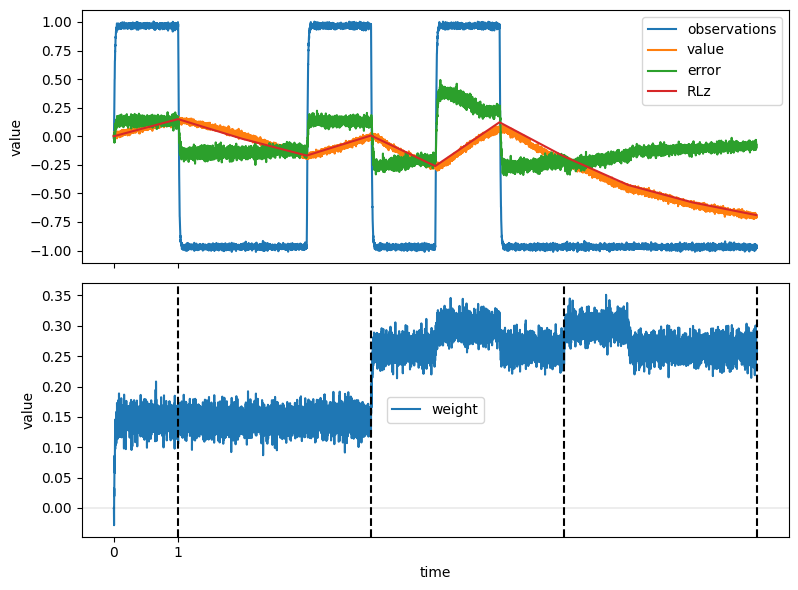

In [14]:
times = sim.trange().flatten()
input_obs = sim.data[net.probe_input_obs].flatten()
obs = sim.data[net.probe_obs].flatten()
weight = sim.data[net.probe_weight].flatten()
error = sim.data[net.probe_error].flatten()
value = sim.data[net.probe_value].flatten()
def cumulative_average(a):
    return np.cumsum(a) / np.arange(1, len(a) + 1)
cumavg = cumulative_average(input_obs)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True)
sns.lineplot(x=times, y=obs, ax=axes[0], label='observations')
sns.lineplot(x=times, y=value, ax=axes[0], label='value')
sns.lineplot(x=times, y=error, ax=axes[0], label='error')
sns.lineplot(x=obs_times, y=RLz, ax=axes[0], label='RLz')
sns.lineplot(x=times, y=weight, ax=axes[1], label='weight')
axes[1].axhline(0, color='k', lw=0.1)
axes[1].axvline(env.T, color='k', ls='--')
axes[1].axvline(env.T+env.n_neighbors*env.T, color='k', ls='--')
axes[1].axvline(env.T+2*env.n_neighbors*env.T, color='k', ls='--')
axes[1].axvline(env.T+3*env.n_neighbors*env.T, color='k', ls='--')
axes[0].set(xlabel='time', ylabel='value')
axes[1].set(xlabel='time', ylabel='value', xticks=np.arange(0, env.T+env.dt, env.T))  # , ylim=(0.0, 0.5)
plt.tight_layout()